# Evaluate CCLM soil moisture with ERA5 and ERA5-Land


Needed: conversion of absolute soil moisture to volumetric soil moisture

volumetric_so = W_SO (m water per layer) * bulk_density (soil g/cm³)

In [8]:
from pathlib import Path

import xarray as xr
import pandas as pd

import valenspy as vp #The Valenspy package
from valenspy.inputconverter_functions import ERA5_to_CF, CCLM_to_CF
from valenspy._utilities import load_xarray_from_data_sources
from valenspy.preprocessing_tasks.select import select_point

from valenspy._utilities import load_yml

from yaml import safe_load

import numpy as np
import matplotlib.pyplot as plt


In [3]:
machine = "hortense"
variable = "tsl"
ref_dataset = "ERA5"

experiments = ["EUR11_NU_TT_EC_TSO", "EUR11_1994_NU_TT_EC_TSO", "EUR11_1993_NU_TT_EC_TSO"]



# Define the coordinates
d_point_coords = {
    'opwijk'    : (4.18, 50.97), 
    'bertrix'    : (5.25, 49.854),
}
point_id = 'opwijk'
point_coord = d_point_coords[point_id]


months_to_analyse = [6,7,8]


# pore volume, hard coded in int2lm source code: https://gitlab.kuleuven.be/rcs/cclm/cosmo_rcs/-/blob/main/int2lm/src/src_2d_fields.f90#L2581 
porosity = np.array([1.E-10,1.E-10, 0.364, 0.445, 0.455, 0.475, 0.507, 0.863, 1.E-10, 1.E-10])



In [4]:
# ERA5 files (manually loaded and converted)
obs_files = ['/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/volumetric_soil_water_layer_1/hourly/era5-hourly-europe-volumetric_soil_water_layer_1-1995.nc', 
'/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/volumetric_soil_water_layer_2/hourly/era5-hourly-europe-volumetric_soil_water_layer_2-1995.nc', 
'/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/volumetric_soil_water_layer_3/hourly/era5-hourly-europe-volumetric_soil_water_layer_3-1995.nc', 
'/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/volumetric_soil_water_layer_4/hourly/era5-hourly-europe-volumetric_soil_water_layer_4-1995.nc']





In [24]:
# 1. manually load ERA5

ds = load_xarray_from_data_sources(obs_files)

# rename dimensions if not yet renamed
if "lon" not in ds.coords:
    ds = ds.rename({"longitude": "lon"})
if "lat" not in ds.coords:
    ds = ds.rename({"latitude": "lat"})

# make sure lat and lon are sorted ascending
ds = ds.sortby('lat').sortby('lon')

# bugfix ERA5 (found in clh): replace valid_time by time
if "time" not in ds: 
    ds = ds.rename({'valid_time':'time'})

ds = ds.resample(time='1D').mean()  


# hardcoded from https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation#ERA5:datadocumentation-Parameterlistings 

era5_soillayers = {'soil_depth': [0.07,0.1,0.28,2.89], 'thickness': [0.07,0.21,0.72,1.89], 
'layer': ['0 - 7 cm','7 - 28 cm', '28 - 100 cm ', '100 - 289 cm']} #m 

da_obs= xr.concat([ds['swvl1'], ds['swvl2'], ds['swvl3'], ds['swvl4']], dim='soil_depth')

da_obs['soil_depth'] = era5_soillayers['soil_depth']

ds_obs = da_obs.to_dataset(name=variable)

# select point from obs

ds_obs_point = ds_obs.sel(lon=point_coord[0],lat=point_coord[1], method='nearest')
da_obs_point = ds_obs_point[variable].sel(time=ds_obs['time'].dt.month.isin(months_to_analyse))
da_obs_point_timmean = da_obs_point.mean('time')


In [26]:
# 2. Load CCLM experiments

# define postprocessing base directory of CCLM
postproc_base_dir = "/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/"

# get experiment name

# get the file directory based on the model name. 

# reference dataset to compare to
model_name = 'CCLM'

# get lookup file for model
mod_LOOKUP = load_yml(model_name+"_lookup")

# get CCLM variable corresponding to the requested variable using its look-up table
mod_var = mod_LOOKUP[variable]['raw_name']

d_da_mod_point = {}
d_ds_mod = {}

for experiment in experiments: 

    # define the path
    directory = Path(postproc_base_dir + experiment +'/'+mod_var + '/daily/')

    # define the CCLM files for the corresponding variable
    cclm_files = list(directory.glob(mod_var+"_daymean.nc")) # Select all the netCDF files in the directory

    #Import Converter - This input converter will not do anything to the data.
    ic = vp.InputConverter(CCLM_to_CF)
    ds_mod = ic.convert_input(cclm_files) # Convert the input to the correct format

    ds_mod = ds_mod.rename({'soil1':'soil_depth'})
    d_ds_mod[experiment] = ds_mod
    ds_mod_point = select_point(ds_mod, point_coord, rotated_pole = True)

    da_mod_point = ds_mod_point[variable].sel(time=ds_mod['time'].dt.month.isin(months_to_analyse))

    soil_depth = np.insert(da_mod_point.soil_depth.values,0,0)
    soil_thickness = np.diff(soil_depth)
    da_mod_point_vol = da_mod_point / (1000*soil_thickness)


    da_mod_point_timmean = da_mod_point_vol

    d_da_mod_point[experiment] = da_mod_point_timmean




/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc31332_inne/ValEnsPy/src/valenspy/_unit_conversions.py:78: UserWarning: Unit conversion for K to K is not implemented for variable tsl.
  warnings.warn(


Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
25.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tsl']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole', 'soil1_bnds']


/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc31332_inne/ValEnsPy/src/valenspy/_unit_conversions.py:78: UserWarning: Unit conversion for K to K is not implemented for variable tsl.
  warnings.warn(


Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
25.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tsl']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole', 'soil1_bnds']
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
25.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tsl']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole', 'soil1_bnds']


/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc31332_inne/ValEnsPy/src/valenspy/_unit_conversions.py:78: UserWarning: Unit conversion for K to K is not implemented for variable tsl.
  warnings.warn(


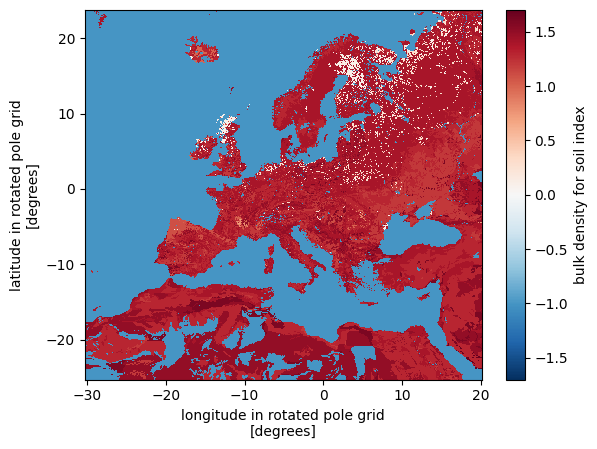

In [ ]:
## load bulk density file

extpar_dir = '/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/extpar_files/'
extpar_file = 'extpar_cordex_ecoclimap_terra_isoil_data_2.nc'

ds_extpar_soil = xr.open_dataset(extpar_dir+extpar_file)
da_bulk_dens = ds_extpar_soil['BULK_DENS']

da_bulk_dens.plot()

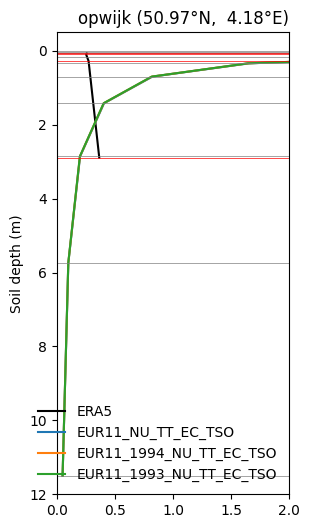

In [25]:
fig, ax = plt.subplots(figsize = (3,6))

ax.plot(da_obs_point_timmean.values, da_obs_point_timmean['soil_depth'].values, color='k', label = ref_dataset)
for experiment in experiments: 
    ax.plot(d_da_mod_point[experiment].mean('time').values, d_da_mod_point[experiment]['soil_depth'].values,  label=experiment)

ax.invert_yaxis()
ax.set_title(' ', loc='center')
ax.set_title(f"{point_id} ({point_coord[1]}°N,  {point_coord[0]}°E)", loc='right');
#ax.set_title(f"Mean soil temperature in {months_to_analyse}", loc='left')
ax.set_ylabel('Soil depth (m)')
ax.set_ylim([12,-0.5])
ax.set_xlim([0,2])
ax.legend(frameon=False, loc='lower right')


for soil_depth in da_mod_point_timmean.soil_depth.values: 
    ax.axhline(soil_depth, color="gray", linewidth = 0.5, label='CCLM soil levels')
    
for soil_depth in da_obs_point_timmean.soil_depth.values: 
    ax.axhline(soil_depth, color="red", linewidth = 0.5, linestyle='-')

In [29]:
da_obs_point_timmean

<xarray.DataArray 'tsl' (soil_depth: 4)> Size: 16B
dask.array<mean_agg-aggregate, shape=(4,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    number      int64 8B 0
    lat         float64 8B 51.0
    lon         float64 8B 4.25
  * soil_depth  (soil_depth) float64 32B 0.07 0.1 0.28 2.89
Attributes: (12/32)
    GRIB_paramId:                             39
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      47107
    GRIB_typeOfLevel:                         depthBelowLandLayer
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               m**3 m**-3
    long_name:                                Volumetric soil water layer 1
    units:                                    m**3 m**-3
    standard_name:                            unknown
    GRIB_depthBelowLandLayer:                 0.0

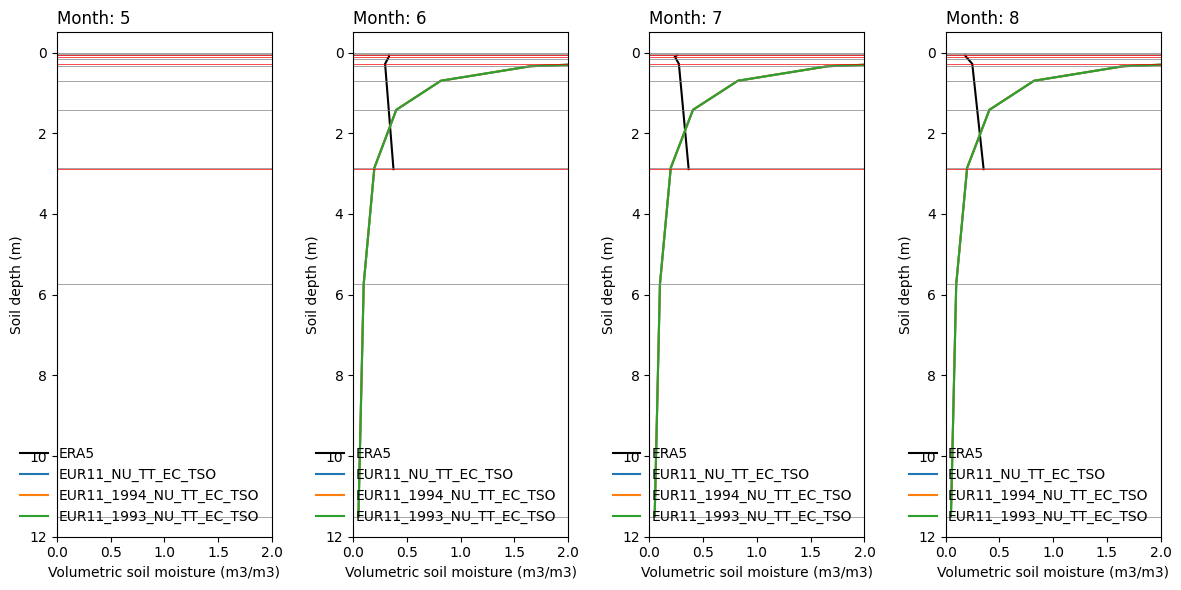

In [31]:
fig, axes = plt.subplots(1,4,figsize = (12,6))
axes = axes.flatten()

for i,month in enumerate([5,6,7,8]): 
    ax= axes[i]



    da_obs_point_timmean = da_obs_point.sel(time=da_obs_point['time'].dt.month.isin(month)).mean('time')


    ax.plot(da_obs_point_timmean.values, da_obs_point_timmean['soil_depth'].values, color='k', label = ref_dataset)
    for experiment in experiments: 

        da_mod_time = d_da_mod_point[experiment].sel(time=d_da_mod_point[experiment]['time'].dt.month.isin(month))
        
        da_mod_time = da_mod_time.sel(time=da_mod_time['time'].dt.year.isin(1995)).mean('time').squeeze()
        ax.plot(da_mod_time.values, da_mod_time['soil_depth'].values,  label=experiment)

    ax.invert_yaxis()
    ax.set_title(' ', loc='center')
    ax.set_title('Month: '+str(month), loc='left')

    #ax.set_title(f"Mean soil temperature in {months_to_analyse}", loc='left')
    ax.set_ylabel('Soil depth (m)')
    ax.set_ylim([12,-0.5])
    ax.set_xlim([0,2])

    ax.set_xlabel('Volumetric soil moisture (m3/m3)')

    ax.legend(frameon=False, loc='lower right')


    for soil_depth in da_mod_point_timmean.soil_depth.values: 
        ax.axhline(soil_depth, color="gray", linewidth = 0.5, label='CCLM soil levels')
        
    for soil_depth in da_obs_point_timmean.soil_depth.values: 
        ax.axhline(soil_depth, color="red", linewidth = 0.5, linestyle='-')

fig.tight_layout()
